In [1]:
from torch.utils.data import DataLoader
import sys
import time

import numpy as np
import  pandas as pd
import  torch
from torchvision import models, transforms,datasets
from PIL import Image
import os
import matplotlib.pyplot as plt
from collections import Counter
from src.model import SkinCancerModel
from src.dataset import MelanomaDataset,data_preprocessing,Normalize
from torch.utils.data import DataLoader
from torch.optim import Adam
import time

# Data preprocessing

In [2]:
dataset_path="..\\dataset"
weights_path="..\\model_weights\\weights.pt"
transform=transforms.Compose([transforms.ToTensor(),Normalize()])

raw_test_path=os.path.join("..\\dataset\\raw",'test')
raw_train_path=os.path.join(dataset_path,"raw",'train')

train_path=os.path.join(dataset_path,"preprocessed",'train')
test_path=os.path.join(dataset_path,"preprocessed",'test')

valid_path=os.path.join(dataset_path,'valid')
class_name_idx={"melanoma":1,"benign":0}
train_data=MelanomaDataset(train_path,class_name_idx,transform)
test_data=MelanomaDataset(test_path,class_name_idx,transform)

In [4]:
resize=transforms.Resize((240,240))
prep_path="../dataset/preprocessed/train"
data_preprocessing(train_path,prep_path,resize)

In [11]:
resize=transforms.Resize((240,240))
prep_path="../dataset/preprocessed/test"
data_preprocessing(raw_test_path,prep_path,resize)

In [3]:
train_loader=DataLoader(train_data,shuffle=True,batch_size=4)

In [4]:
itr=iter(train_data)
img,value=next(itr)
print(img.shape)

torch.Size([3, 240, 240])


In [5]:
test_loader=DataLoader(test_data,shuffle=True,batch_size=1)
img,l=next(iter(test_data))
print(len(test_loader))

1600


In [23]:
for i in range(374):
        img,value=next(itr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1.])


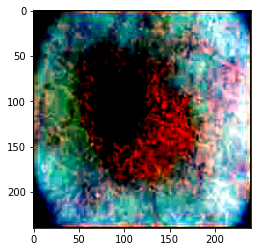

In [16]:
img,value=next(itr)
print(value)
plt.imshow(img.numpy().transpose([1,2,0]))
plt.show()

In [17]:
from src.model import SkinCancerModel

In [20]:
model=SkinCancerModel(True,"efficientnet_b1")


In [19]:
model.load_local_weights(weights_path)

RuntimeError: Error(s) in loading state_dict for SkinCancerModel:
	Missing key(s) in state_dict: "classifier.4.weight", "classifier.4.bias". 
	Unexpected key(s) in state_dict: "classifier.3.weight", "classifier.3.bias". 

In [40]:
model

SkinCancerModel(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation

In [10]:
len(model.features)

9

In [20]:
for i in range(2):
        for par in model.features[i].parameters():
          par.requires_grad=False

In [7]:
model.save_weights("weights.pt")

In [22]:
model.load_local_weights("weights.pt")

In [26]:
from torch.optim import Adam
import time
optimizer=Adam(model.parameters(),lr=0.01)
loss_function=torch.nn.BCELoss()

In [27]:
train_losses_list=[]
test_losses_list=[]
epochs=100
min_train_loss=800000
min_test_loss=800000


In [28]:
import torch.nn as nn
model.classifier=nn.Sequential(nn.Dropout(0.25),nn.Linear(1280,1),nn.Sigmoid())

In [ ]:


no_batches=len(train_loader)


dataset_size=float(len(train_loader.dataset))
model.cuda()
for e in range(epochs):
  train_loss_sum=0.0
  cnt=0.0
  time_sum=0.0
  model.train()
  for img,value in train_loader:
    ts=time.time()
    optimizer.zero_grad()
    img=img.cuda()
    output=model(img)
    value=value.cuda()

    loss=loss_function(output,value)

    loss.backward()
    optimizer.step()
    train_loss_sum+=loss.item()*train_loader.batch_size

    # calculate epoch info
    cnt+=1.0
    finished=int((cnt*10)/no_batches)
    remaining=10-finished
    te=time.time()
    time_sum+=(te-ts)
    avg_time=time_sum/cnt
    time_remaing=avg_time*(no_batches-cnt)
    sys.stdout.flush()
    sys.stdout.write("\r epoch "+str(e+1)+" ["+str("="*int((cnt*10)/no_batches)+str("."*remaining)+"] time remaining = "+str(time_remaing/60.0)[:8]))
    # print()

  train_loss_avg=train_loss_sum/dataset_size
  train_losses_list.append(train_loss_avg)





  #test


  test_loss=0.0
  model.eval()
  with torch.no_grad():
    for img ,label in test_loader:
      img=img.cuda()
      label=label.cuda()
      output=model(img)
      losses=loss_function(output,label)
      test_loss+=losses.item()*test_loader.batch_size


  test_loss/=len(test_loader.dataset)
  test_losses_list.append(test_loss)
  print()
  if train_loss_avg<min_train_loss and test_loss<min_test_loss:
    model.save_weights("weights.pt")
    min_train_loss=train_loss_avg
    min_test_loss=test_loss
    print(f"new train loss ={train_loss_avg } new test loss= {test_loss}")


  if test_loss>train_loss_avg:
    print(" over fitting")


  print(f" epoch {e+1} train_loss ={train_loss_avg} test_loss={test_loss}")


 epoch 1 [==========] time remaining = 0.004652
new train loss =0.40973885693559237 new test loss= 0.4138039416442007
 over fitting
 epoch 1 train_loss =0.40973885693559237 test_loss=0.4138039416442007
 epoch 2 [==........] time remaining = 9.759715

In [10]:
model.cuda()

SkinCancerModel(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation

In [57]:
count=0
loss_test=0.0
melanoma_score_sum=0.0
cnt_melanoma=0
cnt_non_melanoma=0
non_melanona_score_sum=0.0
model.eval()
with torch.no_grad():
  for img ,label in test_loader:
          img=img.cuda()
          label=label.cuda()
          result=model(img)

          if label.item()==1:
            melanoma_score_sum+=result.cpu().item()
            cnt_melanoma+=1
          else:
            non_melanona_score_sum+=result.cpu().item()
            cnt_non_melanoma+=1

          if result>0.4:
                result=1
          else:
                  result=0

          if result==label:
                  count+=1
model.train()

SkinCancerModel(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation

In [58]:
accuracy=(count/len(test_loader))*100
print(accuracy)
print(melanoma_score_sum/cnt_melanoma)
print(non_melanona_score_sum/cnt_non_melanoma)

81.375
0.6549147207114839
0.17197639043305527


In [52]:
torch.cuda.empty_cache()

In [28]:
import torch
ss=torch.tensor([1,2,3])
ss.unsqueeze(1)

tensor([[1],
        [2],
        [3]])